# Project Title: *Evaluating Mildly Conservative Q-Learning for Offline Reinforcement Learning in Grid-World Navigation*

  ## Introduction:
  This project investigates the application of Mildly Conservative Q-Learning (MCQL), an offline reinforcement learning algorithm, in a grid-world navigation task. A dataset of 4,000 A* trajectories was used to train and evaluate a behavior policy modeled with a Conditional Variational Autoencoder (CVAE), achieving ~70% accuracy. Despite low training losses, the target policy trained with MCQL was unable to guide the robot to the goal, highlighting challenges in aligning offline RL training with task-specific performance.







# Uploading map files:
To set up the grid-world environment, we need to upload the map files (map.pgm and map.yaml) that define the occupancy grid and metadata for the environment. These files are used to create the simulation space for the agent.

The following code allows you to upload the required files directly to the Google Colab environment. Once uploaded, these files will be saved locally in the Colab runtime for further processing.
##Instructions:

* Click on the "Choose Files" button in the output cell.
* Select both map.pgm and map.yaml files from your local machine.
* Once the upload is complete, you can proceed to parse and visualize the map in the next steps.

In [ ]:
#Upload map.pgm and map.yaml files to Google Colab
from google.colab import files
uploaded = files.upload()


Saving map.pgm to map (1).pgm
Saving map.yaml to map (1).yaml


# Map Loading and Parsing
The following code defines a Map class to handle the loading and parsing of the grid-world environment from the provided map files (map.pgm and map.yaml). This includes:

##Loading Metadata:

The .yaml file contains metadata about the map, such as resolution, origin, and file references.
The metadata is parsed using the yaml library and converted into a structured DataFrame using pandas.
Processing the Map Image:

The .pgm file is the occupancy grid, representing the environment as an image.
The map image is loaded using the PIL library and converted into a grayscale numpy array for numerical processing.
Key Components:

##Usage:

The Map object is initialized with the map name (e.g., map), automatically loading the associated files (map.yaml and map.pgm).














In [ ]:
import numpy as np
from PIL import Image
import yaml
import pandas as pd

class Map:
    def __init__(self, map_name):
        self.image_array, self.map_df = self.load_map(map_name)

    def load_map(self, map_name):
        # Load map metadata from YAML file
        with open(map_name + '.yaml', 'r') as f:
            map_df = pd.json_normalize(yaml.safe_load(f))

        # Open map image and convert to grayscale
        map_image_name = map_df.image[0]
        map_image = Image.open(map_image_name).convert("L")  # Grayscale

        return np.array(map_image), map_df

# Load the map
map_object = Map('map')


###Run the following cells to visualize the map (optional)

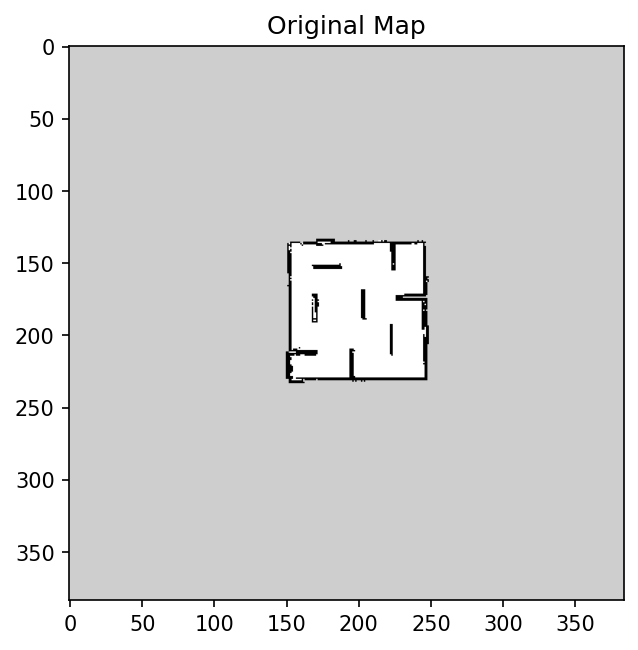

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Display the map
fig, ax = plt.subplots(dpi=150)
ax.imshow(map_object.image_array, cmap=cm.gray)
plt.title("Original Map")
plt.show()


#Map Initialization and Occupancy Grid Creation
This code extends the Map class to include additional functionality for extracting key properties of the map and creating an occupancy grid. The occupancy grid represents free and occupied spaces in the environment, which is essential for defining the navigation space in the grid-world task.

##Key Components
###Attributes:

* resolution: The resolution of the map in meters per pixel, as specified in the .yaml file.
* origin: The bottom-left corner of the map in the global coordinate frame, extracted from the .yaml file.
* width and height: Dimensions of the map image (in pixels).
limits: The physical boundaries of the map in meters, derived using the resolution and origin.
* grid: A binary occupancy grid where:
* 0: Represents free space.
* 1: Represents obstacles.
###Methods:

* load_map:
Reads the .yaml file for map metadata and parses it into a structured DataFrame.
Loads the .pgm file and converts it to a grayscale numpy array for further processing.
* create_occupancy_grid:
Converts the grayscale image into a binary occupancy grid based on thresholds defined in the metadata (free_thresh and occupied_thresh).
Pixels above the free threshold are considered free space, while those below the occupied threshold are treated as obstacles.
### Occupancy Grid Thresholds:

* free_thresh: The threshold for identifying free space, scaled to match pixel intensity (0–255).
* occupied_thresh: The threshold for identifying obstacles, similarly scaled.

###Usage:
Create a Map object by passing the map name (e.g., 'map'). This will:
Load the map image and metadata.
Extract key properties such as resolution, origin, and limits.
Generate a binary occupancy grid for navigation.
###Output:
* map_object.image_array: Grayscale numpy array of the map image.
* map_object.map_df: Metadata parsed from the .yaml file.
* map_object.grid: Binary occupancy grid for navigation.

This grid will be used for data generation and downstream tasks such as policy evaluation.

In [ ]:
import numpy as np
from PIL import Image
import yaml
import pandas as pd

class Map:
    def __init__(self, map_name):
        self.image_array, self.map_df = self.load_map(map_name)
        self.resolution = self.map_df.resolution[0]
        self.origin = self.map_df.origin[0][:2]
        self.width, self.height = self.image_array.shape[1], self.image_array.shape[0]
        self.limits = [
            self.origin[0],
            self.origin[0] + self.width * self.resolution,
            self.origin[1],
            self.origin[1] + self.height * self.resolution
        ]
        self.grid = self.create_occupancy_grid()

    def load_map(self, map_name):
        # Load map metadata from YAML file
        with open(map_name + '.yaml', 'r') as f:
            map_df = pd.json_normalize(yaml.safe_load(f))

        # Open map image and convert to grayscale
        map_image_name = map_df.image[0]
        map_image = Image.open(map_image_name).convert("L")  # Grayscale

        return np.array(map_image), map_df

    def create_occupancy_grid(self):
        # Create occupancy grid
        occupancy_grid = np.zeros_like(self.image_array, dtype=np.uint8)
        # Define thresholds
        free_threshold = int(self.map_df.free_thresh[0] * 255)
        occupied_threshold = int(self.map_df.occupied_thresh[0] * 255)

        # Fill occupancy grid
        occupancy_grid[self.image_array >= free_threshold] = 0  # Free space
        occupancy_grid[self.image_array <= occupied_threshold] = 1  # Obstacles

        return occupancy_grid

# Load the map
map_object = Map('map')


###Run these cells to visualize the occupancy grid (Optional)

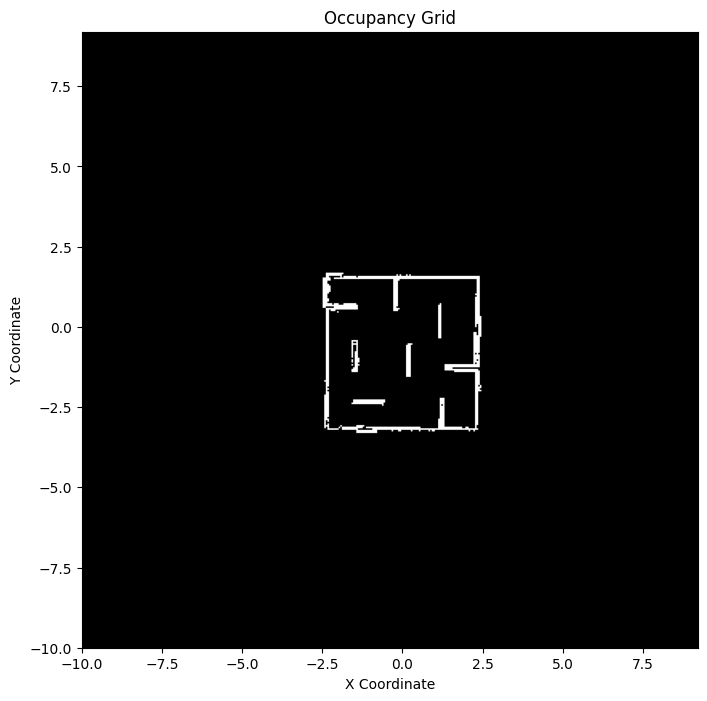

In [ ]:
import matplotlib.pyplot as plt

def plot_occupancy_grid(map_object):
    plt.figure(figsize=(8, 8))
    plt.imshow(map_object.grid, cmap='gray', origin='lower',
               extent=map_object.limits)
    plt.title('Occupancy Grid')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

plot_occupancy_grid(map_object)


### **Dataset Generation using A\***

This section focuses on generating a dataset for offline reinforcement learning using the A\* algorithm to plan trajectories in the grid-world environment. The dataset captures transitions, including states, actions, rewards, next states, and done flags, based on optimal paths from randomly sampled start positions to a predefined goal.

#### **Key Components**:
1. **Goal Setup**:
   - A goal position in the map coordinates (`goal_x`, `goal_y`) is defined. If the goal is not in free space, the nearest free space cell is located and set as the new goal.

2. **Random Start Position**:
   - Start positions are randomly sampled within specified bounds (`x_min`, `x_max`, `y_min`, `y_max`) and validated to be in free space.

3. **A\* Algorithm**:
   - Implements the A\* search algorithm to find optimal paths between start and goal positions, considering the grid-world's occupancy constraints.

4. **Data Collection**:
   - For each valid path:
     - `states`: Current state in map coordinates.
     - `actions`: Difference in grid positions between consecutive steps, representing movement direction.
     - `rewards`: Fixed reward of `-1` per step to encourage shorter paths.
     - `next_states`: Next state in map coordinates.
     - `dones`: A flag indicating whether the current step leads to the goal.

5. **Dataset Structure**:
   - The dataset is stored as a dictionary with keys: `states`, `actions`, `rewards`, `next_states`, `dones`.
   - Each key maps to a numpy array for efficient storage and computation.

6. **Dataset Size**:
   - A total of **4,000 trajectories** are generated. If no valid path is found for a sampled start position, it is skipped.

7. **Saving the Dataset**:
   - The dataset is serialized and saved to a file named `a_star_4000paths.pkl` using the `pickle` module for later use.

#### **Output**:
- A dataset containing state-action-reward transitions derived from A\*-planned paths.
- A saved file `a_star_4000paths.pkl` ready for offline reinforcement learning tasks.

This dataset serves as the foundation for training and evaluating both the approximated behavior and target policies.


In [ ]:
import numpy as np
import heapq
import random
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import yaml
import pandas as pd

# Load and preprocess map
class Map:
    def __init__(self, map_name):
        self.image_array, self.map_df = self.load_map(map_name)
        self.resolution = self.map_df.resolution[0]
        self.origin = self.map_df.origin[0][:2]
        self.grid = self.create_occupancy_grid()
        self.width = self.grid.shape[1]
        self.height = self.grid.shape[0]
        self.limits = [
            self.origin[0],
            self.origin[0] + self.width * self.resolution,
            self.origin[1],
            self.origin[1] + self.height * self.resolution
        ]

    def load_map(self, map_name):
        with open(map_name + '.yaml', 'r') as f:
            map_df = pd.json_normalize(yaml.safe_load(f))
        map_image_name = map_df.image[0]
        map_image = Image.open(map_image_name).convert("L")
        return np.array(map_image), map_df

    def create_occupancy_grid(self):
        occupancy_grid = np.zeros_like(self.image_array, dtype=np.uint8)
        free_threshold = int(self.map_df.free_thresh[0] * 255)
        occupied_threshold = int(self.map_df.occupied_thresh[0] * 255)
        # Set free space
        occupancy_grid[self.image_array >= free_threshold] = 0
        # Set obstacles
        occupancy_grid[self.image_array <= occupied_threshold] = 1
        # Ignore unknown areas (gray regions)
        occupancy_grid[(self.image_array > occupied_threshold) & (self.image_array < free_threshold)] = 1
        return occupancy_grid

# Initialize map
map_object = Map('map')  # Replace 'map' with your actual map name without extension

# Utility functions
def map_to_grid(x, y, map_object):
    j = int((x - map_object.origin[0]) / map_object.resolution)
    i = int((y - map_object.origin[1]) / map_object.resolution)
    # Ensure indices are within bounds
    i = np.clip(i, 0, map_object.height - 1)
    j = np.clip(j, 0, map_object.width - 1)
    return i, j

def grid_to_map(i, j, map_object):
    x = j * map_object.resolution + map_object.origin[0]
    y = i * map_object.resolution + map_object.origin[1]
    return x, y

def is_in_free_space(i, j, map_object):
    return map_object.grid[i, j] == 0

def get_random_start_position(map_object, x_min=-2.0, x_max=2.5, y_min=-2.6, y_max=1.8):
    max_attempts = 1000
    for _ in range(max_attempts):
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
        i, j = map_to_grid(x, y, map_object)
        if is_in_free_space(i, j, map_object):
            return i, j
    raise ValueError("Could not find a valid start position in free space within the specified bounds.")

# Set goal position (arbitrarily selected)
goal_x, goal_y = 1.5, 1.5
goal_i, goal_j = map_to_grid(goal_x, goal_y, map_object)
if not is_in_free_space(goal_i, goal_j, map_object):
    # Find the nearest free space cell
    free_space_indices = np.argwhere(map_object.grid == 0)
    distances = np.linalg.norm(free_space_indices - np.array([goal_i, goal_j]), axis=1)
    nearest_free_space_index = free_space_indices[np.argmin(distances)]
    goal_i, goal_j = nearest_free_space_index
    goal_x, goal_y = grid_to_map(goal_i, goal_j, map_object)
goal_position = (goal_i, goal_j)

# Define A* algorithm
def heuristic(a, b):
    return np.hypot(a[0] - b[0], a[1] - b[1])

def get_neighbors(position, grid):
    i, j = position
    neighbors = []
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1),
                   (-1, -1), (-1, 1), (1, -1), (1, 1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < grid.shape[0] and 0 <= nj < grid.shape[1]:
            if grid[ni, nj] == 0:
                neighbors.append((ni, nj))
    return neighbors

def astar(grid, start, goal):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    g_score = {start: 0}
    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            path.reverse()
            return path
        for neighbor in get_neighbors(current, grid):
            tentative_g_score = g_score[current] + heuristic(current, neighbor)
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(open_set, (f_score, neighbor))
    return None

# Generate dataset
num_trajectories = 4000
dataset = {
    'states': [],
    'actions': [],
    'rewards': [],
    'next_states': [],
    'dones': []
}

for traj_idx in range(num_trajectories):
    if traj_idx == 0 or (traj_idx % 100 == 0):
        print(f"Generating trajectory {traj_idx + 1}/{num_trajectories}")

    try:
        start_i, start_j = get_random_start_position(map_object)
        start_position = (start_i, start_j)
        path = astar(map_object.grid, start_position, goal_position)

        if path is None:
            if traj_idx == 0 or (traj_idx % 100 == 0):
                print(f"  Trajectory {traj_idx + 1}: No path found from start to goal.")
            continue
        else:
            if traj_idx == 0 or (traj_idx % 100 == 0):
                print(f"  Trajectory {traj_idx + 1}: Path found with {len(path)} steps.")

        # Collect data
        for idx in range(len(path) - 1):
            current_pos = path[idx]
            next_pos = path[idx + 1]
            action = (next_pos[0] - current_pos[0], next_pos[1] - current_pos[1])
            # Convert grid positions to map coordinates
            current_state = grid_to_map(current_pos[0], current_pos[1], map_object)
            next_state = grid_to_map(next_pos[0], next_pos[1], map_object)
            # Define reward structure
            reward = -1.0  # Negative reward per step
            # Determine if this is the last step
            done = (idx == len(path) - 2)
            # Append to dataset
            dataset['states'].append(current_state)
            dataset['actions'].append(action)
            dataset['rewards'].append(reward)
            dataset['next_states'].append(next_state)
            dataset['dones'].append(done)
    except ValueError as e:
        if traj_idx == 0 or (traj_idx % 100 == 0 and traj_idx <= 500):
            print(f"  Trajectory {traj_idx + 1}: {e}")
        continue


# Convert lists to numpy arrays
for key in dataset:
    dataset[key] = np.array(dataset[key])

# Save the dataset
with open('a_star_4000paths.pkl', 'wb') as f:
    pickle.dump(dataset, f)
print("Dataset saved as 'a_star_4000paths.pkl'")



Generating trajectory 1/4000
  Trajectory 1: Path found with 26 steps.
Generating trajectory 101/4000
  Trajectory 101: Path found with 63 steps.
Generating trajectory 201/4000
  Trajectory 201: Path found with 79 steps.
Generating trajectory 301/4000
  Trajectory 301: Path found with 72 steps.
Generating trajectory 401/4000
  Trajectory 401: Path found with 59 steps.
Generating trajectory 501/4000
  Trajectory 501: Path found with 71 steps.
Generating trajectory 601/4000
  Trajectory 601: Path found with 31 steps.
Generating trajectory 701/4000
  Trajectory 701: Path found with 80 steps.
Generating trajectory 801/4000
  Trajectory 801: Path found with 43 steps.
Generating trajectory 901/4000
  Trajectory 901: Path found with 72 steps.
Generating trajectory 1001/4000
  Trajectory 1001: Path found with 72 steps.
Generating trajectory 1101/4000
  Trajectory 1101: Path found with 54 steps.
Generating trajectory 1201/4000
  Trajectory 1201: Path found with 67 steps.
Generating trajectory 1

### **Visualization of Random Trajectories (Optional)**

This optional script visualizes three randomly selected trajectories from the generated dataset. Each trajectory is overlaid on the grid-world environment, showing:

- **Red Line**: The trajectory path.
- **Green Marker**: Start position.
- **Blue Marker**: Goal position.

In [ ]:
# Plot 3 random trajectories
def plot_trajectory(path, map_object, trajectory_number):
    path_coords = [grid_to_map(pos[0], pos[1], map_object) for pos in path]
    x_coords, y_coords = zip(*path_coords)
    plt.figure(figsize=(8, 8))
    plt.imshow(map_object.grid, cmap='gray', origin='lower',
               extent=map_object.limits)
    plt.plot(x_coords, y_coords, '-r', label=f'Trajectory {trajectory_number}')
    plt.scatter(x_coords[0], y_coords[0], c='green', label='Start')
    plt.scatter(x_coords[-1], y_coords[-1], c='blue', label='Goal')
    plt.title(f'Trajectory {trajectory_number}')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

# Select 3 random trajectories to plot
num_states = len(dataset['states'])
if num_states == 0:
    print("No trajectories generated to plot.")
else:
    # Reconstruct trajectories from the dataset
    indices = [i for i, done in enumerate(dataset['dones']) if done]
    trajectory_starts = [0] + [idx + 1 for idx in indices[:-1]]
    trajectory_indices = list(zip(trajectory_starts, indices))

    # Randomly select 3 trajectories
    if len(trajectory_indices) < 3:
        trajectories_to_plot = trajectory_indices
    else:
        trajectories_to_plot = random.sample(trajectory_indices, 3)

    for idx, (start_idx, end_idx) in enumerate(trajectories_to_plot):
        # Get the grid positions from the states
        trajectory_states = dataset['states'][start_idx:end_idx+1]
        path = [map_to_grid(state[0], state[1], map_object) for state in trajectory_states]
        plot_trajectory(path, map_object, idx + 1)


NameError: name 'dataset' is not defined

### **Behavior Policy Fitting using Conditional Variational Autoencoder (CVAE)**

This section implements and trains a Conditional Variational Autoencoder (CVAE) to model the behavior policy, predicting the next state given the current state. The process involves:

#### **Data Preprocessing**
- **Normalization**: States and next states are normalized using `StandardScaler` to ensure numerical stability during training.
- **Visualization**:
  - Histograms of raw and normalized states are plotted to compare distributions before and after scaling.
- **Data Preparation**: Normalized states are converted to PyTorch tensors and wrapped in a custom `BehaviorDataset` for efficient loading.

#### **CVAE Model**
- **Architecture**:
  - **Encoder**: Maps the concatenated state and next-state pair to a latent space (`mu` and `logvar`).
  - **Decoder**: Predicts the next state using the current state and a latent variable sampled from the latent space.
  - **Latent Dimensionality**: Configurable, defaulting to 8.
- **Loss Function**:
  - **Reconstruction Loss**: Measures the mean squared error (MSE) between predicted and true next states.
  - **KL Divergence Loss**: Encourages the latent space to approximate a standard normal distribution.

#### **Training the CVAE**
- **Training Process**:
  - Batch size: 128
  - Optimizer: Adam with a learning rate of 1e-3
  - Number of epochs: 10
- **Output**:
  - Reconstruction loss and KL divergence loss are reported after each epoch.
  - The trained model is saved as `cvae_waypoint_model4.pt`.

#### **Saved Artifacts**
- Fitted `StandardScaler` objects for states and next states (`state_scaler.pkl` and `next_state_scaler.pkl`).
- The trained CVAE model weights (`cvae_waypoint_model4.pt`).

This trained behavior model approximates the transition dynamics and serves as the foundation for offline RL training.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle

# Load the dataset
with open('/content/drive/My Drive/Colab Notebooks/ECE595/a_star_4000paths.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Extract states and next states
states = np.array(dataset_dict['states'])
next_states = np.array(dataset_dict['next_states'])

# Visualize raw state and next-state distributions
plt.hist(states.ravel(), bins=50, alpha=0.5, label="Raw States")
plt.hist(next_states.ravel(), bins=50, alpha=0.5, label="Raw Next States")
plt.title("Before Scaling")
plt.legend()
plt.show()

# Preprocess the data (Normalization)
state_scaler = StandardScaler()
next_state_scaler = StandardScaler()

states_scaled = state_scaler.fit_transform(states)
next_states_scaled = next_state_scaler.fit_transform(next_states)

# Visualize normalized state and next-state distributions
plt.hist(states_scaled.ravel(), bins=50, alpha=0.5, label="Normalized States")
plt.hist(next_states_scaled.ravel(), bins=50, alpha=0.5, label="Normalized Next States")
plt.title("After Scaling")
plt.legend()
plt.show()

states_tensor = torch.tensor(states_scaled, dtype=torch.float32)
next_states_tensor = torch.tensor(next_states_scaled, dtype=torch.float32)

# Debug: Check scaler statistics
print("State Scaler Statistics:")
print(f"  Mean: {state_scaler.mean_}")
print(f"  Std: {state_scaler.scale_}")

print("Next State Scaler Statistics:")
print(f"  Mean: {next_state_scaler.mean_}")
print(f"  Std: {next_state_scaler.scale_}")

# Debug: Check normalized ranges
print("Normalized States (Training):")
print(f"  Min: {states_scaled.min(axis=0)}")
print(f"  Max: {states_scaled.max(axis=0)}")

print("Normalized Next States (Training):")
print(f"  Min: {next_states_scaled.min(axis=0)}")
print(f"  Max: {next_states_scaled.max(axis=0)}")

# Ensure correct dimensions
print(f"States Shape: {states.shape}")
print(f"Next States Shape: {next_states.shape}")

# Save the fitted scalers for later use
with open('state_scaler.pkl', 'wb') as f:
    pickle.dump(state_scaler, f)

with open('next_state_scaler.pkl', 'wb') as f:
    pickle.dump(next_state_scaler, f)

print("Scalers saved as 'state_scaler.pkl' and 'next_state_scaler.pkl'.")

# Define the BehaviorDataset class
class BehaviorDataset(Dataset):
    def __init__(self, states, next_states):
        self.states = states
        self.next_states = next_states

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.next_states[idx]

# Create dataset and dataloader
dataset = BehaviorDataset(states_tensor, next_states_tensor)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the CVAE model
class CVAE(nn.Module):
    def __init__(self, state_dim, latent_dim=2, hidden_dim=64):
        super(CVAE, self).__init__()
        self.state_dim = state_dim
        self.latent_dim = latent_dim

        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(state_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(state_dim + latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, state, z):
        x = torch.cat([state, z], dim=1)
        return self.decoder(x)

    def forward(self, state, next_state):
        # Encode
        x = torch.cat([state, next_state], dim=1)
        mu, logvar = self.encode(x)
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        # Decode
        recon_next_state = self.decode(state, z)
        return recon_next_state, mu, logvar

# Define the loss function for waypoint prediction
def waypoint_loss_function(recon_next_state, true_next_state, mu, logvar):
    # Reconstruction loss (MSE between predicted and true next states)
    recon_loss = nn.MSELoss()(recon_next_state, true_next_state)
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / true_next_state.size(0)
    return recon_loss, KLD

# Define a training function
def train_model(model, optimizer, dataloader, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_recon_loss = 0
        total_kl_loss = 0

        for batch_states, batch_next_states in dataloader:
            optimizer.zero_grad()
            recon_next_states, mu, logvar = model(batch_states, batch_next_states)

            # Calculate losses
            recon_loss, kl_loss = waypoint_loss_function(recon_next_states, batch_next_states, mu, logvar)
            loss = recon_loss + kl_loss

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            # Accumulate losses for reporting
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()

        # Average losses for the epoch
        avg_recon_loss = total_recon_loss / len(dataloader)
        avg_kl_loss = total_kl_loss / len(dataloader)

        print(f"Epoch [{epoch+1}/{num_epochs}], Reconstruction Loss: {avg_recon_loss:.6f}, KL Divergence Loss: {avg_kl_loss:.6f}")

    return avg_recon_loss, avg_kl_loss

# Initialize and train the CVAE
latent_dim = 8
hidden_dim = 128
learning_rate = 1e-3
num_epochs = 10

state_dim = states_tensor.shape[1]
model = CVAE(state_dim, latent_dim, hidden_dim)
optimizer = Adam(model.parameters(), lr=learning_rate)

print("Training the CVAE...")
train_model(model, optimizer, dataloader, num_epochs)

# Save the trained model
torch.save(model.state_dict(), 'cvae_waypoint_model4.pt')
print("Model saved as 'cvae_waypoint_model4.pt'.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/ECE595/a_star_4000paths.pkl'

### **Path Generation using the Trained CVAE**

This section demonstrates generating a path in the grid-world environment using the trained Conditional Variational Autoencoder (CVAE) as the behavior policy.

#### **Steps**:
1. **Initialize Start Position**:
   - A random valid starting position is selected within the grid-world bounds.

2. **Path Generation**:
   - The CVAE predicts the next state iteratively, starting from the initial position.
   - Each predicted state is validated to ensure it lies within free space.
   - The process continues until the goal is reached or the maximum number of steps is exceeded.

3. **Validation of Predicted States**:
   - If the predicted state lies in an obstacle, the model resamples from the latent space to find a valid state.

4. **Stopping Criteria**:
   - The path generation terminates when the agent is within a specified threshold of the goal or if it fails to find a valid next state.

5. **Visualization**:
   - The generated path is plotted on the grid-world map:
     - **Blue Path**: Path taken by the agent.
     - **Green Marker**: Start position.
     - **Red Marker**: Goal position.

#### **Outputs**:
- A detailed trajectory of the agent's path.
- Visualization of the path on the map, highlighting the agent's start and goal positions.

This demonstrates how the trained CVAE can be used as a behavior policy to guide the agent through the environment.


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import pickle
from PIL import Image
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# -------------------------------
# Step 1: Load and Process Map
# -------------------------------
class Map:
    def __init__(self, map_name):
        self.image_array, self.map_df = self.load_map(map_name)
        self.resolution = self.map_df.resolution[0]
        self.origin = self.map_df.origin[0][:2]
        self.grid = self.create_occupancy_grid()
        self.width = self.grid.shape[1]
        self.height = self.grid.shape[0]
        self.limits = [
            self.origin[0],
            self.origin[0] + self.width * self.resolution,
            self.origin[1],
            self.origin[1] + self.height * self.resolution
        ]

    def load_map(self, map_name):
        with open(map_name + '.yaml', 'r') as f:
            map_df = pd.json_normalize(yaml.safe_load(f))
        map_image_name = map_df.image[0]
        map_image = Image.open(map_image_name).convert("L")
        return np.array(map_image), map_df

    def create_occupancy_grid(self):
        occupancy_grid = np.zeros_like(self.image_array, dtype=np.uint8)
        free_threshold = int(self.map_df.free_thresh[0] * 255)
        occupied_threshold = int(self.map_df.occupied_thresh[0] * 255)
        occupancy_grid[self.image_array >= free_threshold] = 0
        occupancy_grid[self.image_array <= occupied_threshold] = 1
        occupancy_grid[(self.image_array > occupied_threshold) & (self.image_array < free_threshold)] = 1
        return occupancy_grid

map_object = Map('map')  # Replace 'map' with your actual map name

# Utility functions
def map_to_grid(x, y, map_object):
    j = int((x - map_object.origin[0]) / map_object.resolution)
    i = int((y - map_object.origin[1]) / map_object.resolution)
    i = np.clip(i, 0, map_object.height - 1)
    j = np.clip(j, 0, map_object.width - 1)
    return i, j

def grid_to_map(i, j, map_object):
    x = j * map_object.resolution + map_object.origin[0]
    y = i * map_object.resolution + map_object.origin[1]
    return x, y

def is_in_free_space(i, j, map_object):
    return map_object.grid[i, j] == 0

def get_random_start_position(map_object, x_min=-2.0, x_max=2.5, y_min=-2.6, y_max=1.8):
    max_attempts = 1000
    for _ in range(max_attempts):
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
        i, j = map_to_grid(x, y, map_object)
        if is_in_free_space(i, j, map_object):
            return x, y
    raise ValueError("Could not find a valid start position in free space.")

goal_x, goal_y = 1.5, 1.5
goal_position = (goal_x, goal_y)

# -------------------------------
# Step 2: Define the CVAE Model
# -------------------------------
class CVAE(nn.Module):
    def __init__(self, state_dim, latent_dim=8, hidden_dim=128):
        super(CVAE, self).__init__()
        self.state_dim = state_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(state_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(state_dim + latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, state, z):
        x = torch.cat([state, z], dim=1)
        return self.decoder(x)

    def forward(self, state, next_state):
        x = torch.cat([state, next_state], dim=1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_next_state = self.decode(state, z)
        return recon_next_state, mu, logvar

# Load the trained model
state_dim = 2
latent_dim = 8
hidden_dim = 128
model = CVAE(state_dim, latent_dim, hidden_dim)
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/ECE595/cvae_waypoint_model4.pt'))
model.eval()

# Load the dataset and scalers
with open('/content/drive/My Drive/Colab Notebooks/ECE595/a_star_4000paths.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)
states = np.array(dataset_dict['states'])
next_states = np.array(dataset_dict['next_states'])

state_scaler = StandardScaler().fit(states)
next_state_scaler = StandardScaler().fit(next_states)

# -------------------------------
# Step 3: Evaluation
# -------------------------------
def evaluate_trajectories(num_samples=100, max_steps=100, output_csv='/content/drive/My Drive/Colab Notebooks/ECE595/evaluation_results.csv'):
    results = []
    success_count = 0
    collision_count = 0
    cumulative_rewards = []

    for _ in tqdm(range(num_samples), desc="Evaluating Trajectories"):
        start_x, start_y = get_random_start_position(map_object)
        path = []
        current_state = np.array([start_x, start_y])
        total_reward = 0
        success = False
        collision = False

        for step in range(max_steps):
            current_state_scaled = state_scaler.transform(current_state.reshape(1, -1))
            current_state_tensor = torch.tensor(current_state_scaled, dtype=torch.float32)
            z = torch.randn(1, model.latent_dim)
            with torch.no_grad():
                recon_next_state_scaled = model.decode(current_state_tensor, z)
            next_state = next_state_scaler.inverse_transform(recon_next_state_scaled.numpy()).flatten()
            next_i, next_j = map_to_grid(next_state[0], next_state[1], map_object)

            if not is_in_free_space(next_i, next_j, map_object):
                collision = True
                collision_count += 1
                break

            path.append(next_state)
            distance_to_goal = np.linalg.norm(next_state - np.array(goal_position))
            total_reward += -1

            if distance_to_goal < 0.2:
                success = True
                success_count += 1
                total_reward += 100
                break

            current_state = next_state

        cumulative_rewards.append(total_reward)
        results.append({
            "Start": (start_x, start_y),
            "Goal": goal_position,
            "Success": "Yes" if success else "No",
            "Collision": "Yes" if collision else "No",
            "Cumulative Reward": total_reward,
            "Path Length": len(path)
        })

    success_rate = (success_count / num_samples) * 100
    collision_rate = (collision_count / num_samples) * 100
    avg_reward = np.mean(cumulative_rewards)

    print(f"\nSuccess Rate: {success_rate:.2f}%")
    print(f"Collision Rate: {collision_rate:.2f}%")
    print(f"Average Cumulative Reward: {avg_reward:.2f}")

    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

evaluate_trajectories()


<ipython-input-25-133b5db038a8>:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/ECE595/cvae_wayp


Success Rate: 53.00%
Collision Rate: 44.00%
Average Cumulative Reward: 19.73
Results saved to /content/drive/My Drive/Colab Notebooks/ECE595/evaluation_results.csv


### **MCQ Training with Behavior and Policy Actions**

This section implements the Mildly Conservative Q-learning (MCQ) algorithm for offline reinforcement learning using the pre-trained Conditional Variational Autoencoder (CVAE) for behavior modeling and Gaussian policies for target action sampling.

#### **Steps**:

1. **Device Setup**:
   - Utilizes GPU if available for faster training.

2. **Dataset Preparation**:
   - Data from the offline dataset is scaled and converted into tensors for PyTorch processing.
   - Includes transitions (`states`, `actions`, `rewards`, `next_states`, `dones`) in a `DataLoader` for batch training.

3. **Distance-Based Reward Shaping**:
   - Rewards are redefined based on the agent's proximity to the goal:
     - **Closer to goal**: Higher reward.
     - **Goal Reached**: Maximum reward of `1.0`.

4. **Model Loading**:
   - The CVAE is loaded to generate behavior actions based on the dataset.
   - The CVAE uses the `next_states` as actions in this framework.

5. **MCQ Algorithm**:
   - **Q-Networks**: Two Q-networks (`q1`, `q2`) and their respective target networks are initialized.
   - **Actor Network**: Gaussian policy model to sample actions.
   - **Conservative Penalty**:
     - Penalty calculated based on the difference between Q-values of behavior actions (`a_b`) and policy actions (`a_pi`).
   - **Loss Functions**:
     - Q-Loss: Combines TD error with the conservative penalty.
     - Actor Loss: Maximizes policy value while incorporating entropy regularization.

6. **Training**:
   - Updates Q-networks and actor network iteratively over multiple epochs.
   - Includes soft updates to Q-target networks for stability.

7. **Hyperparameters**:
   - `alpha`: Entropy regularization parameter.
   - `gamma`: Discount factor.
   - `lambda_conservatism`: Weight for the conservative penalty.
   - `tau`: Soft update rate for target networks.
   - `N`: Number of policy action samples for conservative penalty.

8. **Saving Models**:
   - Trained models are saved:
     - Actor model: `mcq_actor_bestparams.pt`
     - Q-network models: `mcq_q1_bestparams.pt` and `mcq_q2_bestparams.pt`.

#### **Output**:
- Training loss values for Q-networks and actor network are reported per epoch.
- Final trained models are saved for future evaluation.




In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pickle
from sklearn.preprocessing import StandardScaler

# =======================================
# Device Setup
# =======================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =======================================
# Load Dataset
# =======================================
with open('/content/drive/My Drive/Colab Notebooks/ECE595/a_star_4000paths.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

states = np.array(dataset_dict['states'], dtype=np.float32)
rewards = np.array(dataset_dict['rewards'], dtype=np.float32)
next_states = np.array(dataset_dict['next_states'], dtype=np.float32)
dones = np.array(dataset_dict['dones'], dtype=np.float32)

# Since original actions are discrete and we're using next_states as continuous actions
actions = next_states.copy()

# =======================================
# Distance-Based Reward Shaping
# =======================================
# Define the goal as in the behavior policy
goal = np.array([1.5, 1.5], dtype=np.float32)
new_rewards = np.zeros_like(rewards)

for i in range(len(rewards)):
    dist = np.linalg.norm(next_states[i, :2] - goal)
    if dones[i] == 1.0:
        new_rewards[i] = 1.0
    else:
        new_rewards[i] = 1.0 / (1.0 + dist)

rewards = new_rewards

# =======================================
# State and Action Scaling
# =======================================
state_scaler = StandardScaler()
action_scaler = StandardScaler()

states_scaled = state_scaler.fit_transform(states)
actions_scaled = action_scaler.fit_transform(next_states)  # Using next_states as actions

# Convert scaled data to tensors
states_tensor = torch.tensor(states_scaled, dtype=torch.float32, device=device)
actions_tensor = torch.tensor(actions_scaled, dtype=torch.float32, device=device)
rewards_tensor = torch.tensor(rewards.reshape(-1, 1), dtype=torch.float32, device=device)
dones_tensor = torch.tensor(dones.reshape(-1, 1), dtype=torch.float32, device=device)

# Prepare next states (for target computation)
next_states_scaled = state_scaler.transform(next_states)
next_states_tensor = torch.tensor(next_states_scaled, dtype=torch.float32, device=device)

# =======================================
# Dataset and Dataloader
# =======================================
class TransitionDataset(Dataset):
    def __init__(self, s, a, r, s_next, d):
        self.s = s
        self.a = a
        self.r = r
        self.s_next = s_next
        self.d = d

    def __len__(self):
        return len(self.s)

    def __getitem__(self, idx):
        return self.s[idx], self.a[idx], self.r[idx], self.s_next[idx], self.d[idx]

batch_size = 128
dataset = TransitionDataset(states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# =======================================
# Load the CVAE Model for Behavior Actions
# (Next state as action)
# =======================================
class CVAE(nn.Module):
    def __init__(self, state_dim, latent_dim=8, hidden_dim=128):
        super(CVAE, self).__init__()
        self.state_dim = state_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(state_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(state_dim + latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )

    def encode(self, state, next_state):
        x = torch.cat([state, next_state], dim=1)
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, state, z):
        x = torch.cat([state, z], dim=1)
        return self.decoder(x)

    def forward(self, state, next_state):
        mu, logvar = self.encode(state, next_state)
        z = self.reparameterize(mu, logvar)
        recon_next_state = self.decode(state, z)
        return recon_next_state, mu, logvar

state_dim = states_tensor.shape[1]
cvae_model = CVAE(state_dim, latent_dim=8, hidden_dim=128).to(device)
cvae_model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/ECE595/cvae_waypoint_model4.pt', map_location=device))
cvae_model.eval()

# =======================================
# MCQ Hyperparameters
# =======================================
action_dim = actions_tensor.shape[1] # same as state_dim if next_state used as action
hidden_dim = 256
alpha = 0.0001
gamma = 0.95
lambda_conservatism = 1.0
tau = 0.005
N = 10
num_epochs = 10

# =======================================
# Q and Policy Networks
# =======================================
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, s, a):
        x = torch.cat([s, a], dim=1)
        return self.net(x)

class GaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(GaussianPolicy, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)

    def forward(self, s):
        h = self.fc(s)
        mean = self.mean(h)
        log_std = self.log_std(h).clamp(-20, 2)
        std = torch.exp(log_std)
        return mean, std

    def sample(self, s):
        mean, std = self.forward(s)
        eps = torch.randn_like(mean)
        a = mean + std * eps
        log_prob = (-0.5 * ((a - mean) / (std + 1e-6)).pow(2)
                    - torch.log(std + 1e-6)
                    - 0.5 * np.log(2 * np.pi)).sum(dim=1, keepdim=True)
        return a, log_prob, mean, std

def soft_update(net, net_target, tau):
    for param, target_param in zip(net.parameters(), net_target.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

@torch.no_grad()
def sample_behavior_actions(s_in, N=1):
    s_in = s_in.to(device)
    batch_size = s_in.size(0)
    a_samples = []
    for _ in range(N):
        z = torch.randn(batch_size, cvae_model.latent_dim, device=device)
        a_sample = cvae_model.decode(s_in, z)
        a_samples.append(a_sample)
    return torch.mean(torch.stack(a_samples, dim=1), dim=1)

@torch.no_grad()
def sample_policy_actions(s_in, N=1):
    s_in = s_in.to(device)
    a_list = []
    for _ in range(N):
        a, _, _, _ = actor.sample(s_in)
        a_list.append(a)
    return torch.mean(torch.stack(a_list, dim=1), dim=1)

q1 = QNetwork(state_dim, action_dim, hidden_dim).to(device)
q2 = QNetwork(state_dim, action_dim, hidden_dim).to(device)
q1_target = QNetwork(state_dim, action_dim, hidden_dim).to(device)
q2_target = QNetwork(state_dim, action_dim, hidden_dim).to(device)
q1_target.load_state_dict(q1.state_dict())
q2_target.load_state_dict(q2.state_dict())

actor = GaussianPolicy(state_dim, action_dim, hidden_dim).to(device)

q_optimizer = optim.Adam(list(q1.parameters()) + list(q2.parameters()), lr=3e-4)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)

q1.train()
q2.train()
actor.train()

for epoch in range(num_epochs):
    total_q_loss = 0.0
    total_actor_loss = 0.0
    count = 0
    for batch in dataloader:
        s, a, r, s_next, d = [x.to(device) for x in batch]

        # Compute target Q values
        with torch.no_grad():
            a_next, log_pi_next, _, _ = actor.sample(s_next)
            q1_next = q1_target(s_next, a_next)
            q2_next = q2_target(s_next, a_next)
            q_next = torch.min(q1_next, q2_next) - alpha * log_pi_next
            y = r + (1 - d) * gamma * q_next

        # Compute conservative penalty
        s_in = torch.cat([s, s_next], dim=0)
        a_pi_in = sample_policy_actions(s_in, N)
        a_b_in = sample_behavior_actions(s_in, N=1)

        q1_in_pi = q1(s_in, a_pi_in)
        q2_in_pi = q2(s_in, a_pi_in)
        q_in_pi = torch.min(q1_in_pi, q2_in_pi)

        q1_in_b = q1(s_in, a_b_in)
        q2_in_b = q2(s_in, a_b_in)
        q_in_b = torch.min(q1_in_b, q2_in_b)

        penalty = (q_in_pi - q_in_b).clamp(min=0).mean()

        # Q loss
        q1_pred = q1(s, a)
        q2_pred = q2(s, a)
        q_loss = ((q1_pred - y.detach())**2).mean() + ((q2_pred - y.detach())**2).mean()
        q_loss = q_loss + lambda_conservatism * penalty

        q_optimizer.zero_grad()
        q_loss.backward()
        q_optimizer.step()

        # Actor loss
        a_pi, log_pi, _, _ = actor.sample(s)
        q1_pi = q1(s, a_pi)
        q2_pi = q2(s, a_pi)
        q_pi = torch.min(q1_pi, q2_pi)
        actor_loss = (alpha * log_pi - q_pi).mean()

        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # Soft update targets
        soft_update(q1, q1_target, tau)
        soft_update(q2, q2_target, tau)

        total_q_loss += q_loss.item()
        total_actor_loss += actor_loss.item()
        count += 1

    avg_q_loss = total_q_loss / count
    avg_actor_loss = total_actor_loss / count
    print(f"Epoch [{epoch+1}/{num_epochs}]: Q Loss: {avg_q_loss:.4f}, Actor Loss: {avg_actor_loss:.4f}")

# Save Models
torch.save(actor.state_dict(), 'mcq_actor_bestparams.pt')
torch.save(q1.state_dict(), 'mcq_q1_bestparams.pt')
torch.save(q2.state_dict(), 'mcq_q2_bestparams.pt')
print("MCQ training completed and models saved.")


Using device: cuda


<ipython-input-17-1f60facdbcd5>:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cvae_model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/ECE595/cvae

Epoch [1/10]: Q Loss: 0.1228, Actor Loss: -1.8178
Epoch [2/10]: Q Loss: 0.0799, Actor Loss: -3.7255
Epoch [3/10]: Q Loss: 0.0246, Actor Loss: -4.6938
Epoch [4/10]: Q Loss: 0.0212, Actor Loss: -5.1436
Epoch [5/10]: Q Loss: 0.0196, Actor Loss: -5.3694
Epoch [6/10]: Q Loss: 0.0206, Actor Loss: -5.4631
Epoch [7/10]: Q Loss: 0.0203, Actor Loss: -5.5095
Epoch [8/10]: Q Loss: 0.0196, Actor Loss: -5.5346
Epoch [9/10]: Q Loss: 0.0198, Actor Loss: -5.5445
Epoch [10/10]: Q Loss: 0.0202, Actor Loss: -5.5351
MCQ training completed and models saved.


###Plots the Q Loss and Actor Lossduring training.

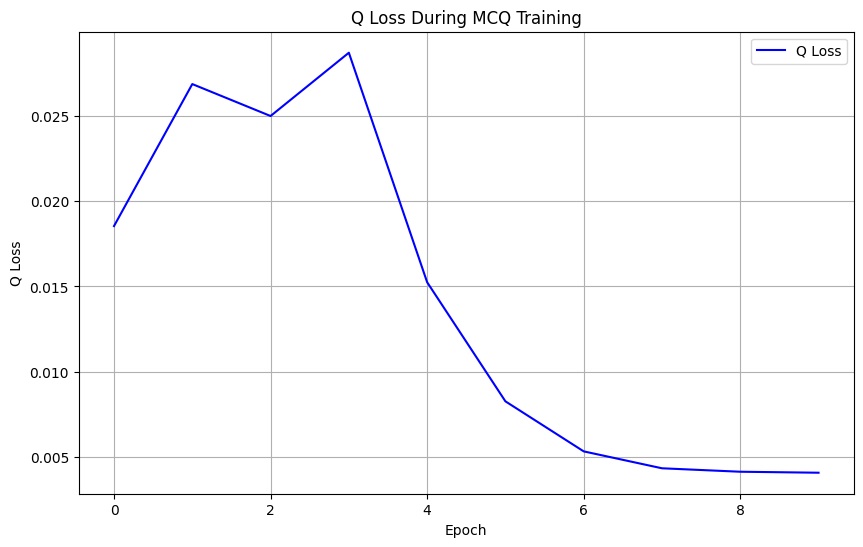

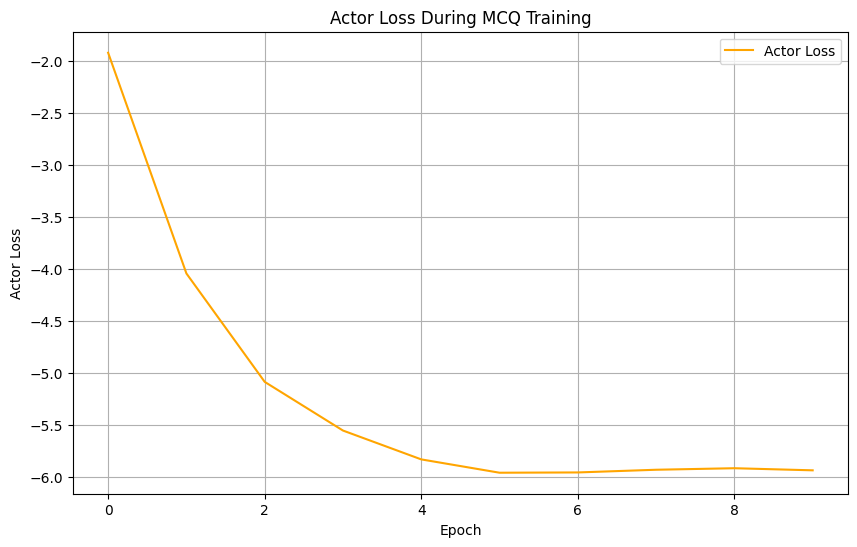

In [ ]:
import matplotlib.pyplot as plt

# Plot Q Loss separately
plt.figure(figsize=(10, 6))
plt.plot(q_losses, label='Q Loss', color='blue')
plt.title('Q Loss During MCQ Training')
plt.xlabel('Epoch')
plt.ylabel('Q Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Actor Loss separately
plt.figure(figsize=(10, 6))
plt.plot(actor_losses, label='Actor Loss', color='orange')
plt.title('Actor Loss During MCQ Training')
plt.xlabel('Epoch')
plt.ylabel('Actor Loss')
plt.legend()
plt.grid(True)
plt.show()


### **Evaluation of Target Policy**

This section evaluates the target policy trained using the Mildly Conservative Q-learning (MCQ) algorithm by generating paths in the grid-world environment and calculating the success rate.

#### **Steps**:

1. **Dataset and Scalers**:
   - Reloads the dataset and refits the `StandardScaler` objects to ensure proper normalization of states and actions.

2. **Map Initialization**:
   - Initializes the grid-world map and defines utility functions to:
     - Map coordinates to grid indices.
     - Identify valid positions in free space.

3. **Set Goal Position**:
   - Defines the goal position as `(1.5, 1.5)` in map coordinates.
   - Adjusts to the nearest free space if the specified goal is not valid.

4. **Load the Target Policy**:
   - Loads the Gaussian policy network trained with MCQ, which predicts the next state (treated as the action).

5. **Path Generation**:
   - Starts from a random valid position.
   - Uses the target policy to iteratively predict the next state until:
     - The agent reaches the goal (within a threshold of 0.2 units).
     - The maximum number of steps (100) is exceeded.
     - An invalid state is encountered.

6. **Evaluation**:
   - Conducts 100 test runs of the policy.
   - Records whether each run successfully reaches the goal.
   - Divides the tests into batches of 10 to compute batch success rates.
   - Calculates the overall success rate across all test runs.

7. **Output**:
   - **Success Rates**:
     - Batch-wise success rates are reported for every 10 runs.
     - The overall success rate is calculated and displayed.
   - **Results Storage**:
     - The results (start position, goal position, success flag) are saved to a CSV file named `target4000.csv`.

#### **Purpose**:
- This evaluation measures the effectiveness of the target policy in guiding the agent to the goal in the grid-world environment.
- The results highlight the generalization ability and robustness of the trained MCQ policy.



In [ ]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from PIL import Image
import yaml
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch.nn as nn

# =======================================
# Load the Dataset and Fit Scalers
# =======================================
with open('/content/drive/My Drive/Colab Notebooks/ECE595/a_star_4000paths.pkl', 'rb') as f:
    dataset = pickle.load(f)

states = dataset['states']  # (N, 2)
next_states = dataset['next_states']  # (N, 2)

state_scaler = StandardScaler()
state_scaler.fit(states)

next_state_scaler = StandardScaler()
next_state_scaler.fit(next_states)

# =======================================
# Map Loading and Utility Functions
# =======================================
class Map:
    def __init__(self, map_name):
        self.image_array, self.map_df = self.load_map(map_name)
        self.resolution = self.map_df.resolution[0]
        self.origin = self.map_df.origin[0][:2]
        self.grid = self.create_occupancy_grid()
        self.width = self.grid.shape[1]
        self.height = self.grid.shape[0]
        self.limits = [
            self.origin[0],
            self.origin[0] + self.width * self.resolution,
            self.origin[1],
            self.origin[1] + self.height * self.resolution
        ]

    def load_map(self, map_name):
        with open(map_name + '.yaml', 'r') as f:
            map_df = pd.json_normalize(yaml.safe_load(f))
        map_image_name = map_df.image[0]
        map_image = Image.open(map_image_name).convert("L")
        return np.array(map_image), map_df

    def create_occupancy_grid(self):
        occupancy_grid = np.zeros_like(self.image_array, dtype=np.uint8)
        free_threshold = int(self.map_df.free_thresh[0] * 255)
        occupied_threshold = int(self.map_df.occupied_thresh[0] * 255)
        occupancy_grid[self.image_array >= free_threshold] = 0
        occupancy_grid[self.image_array <= occupied_threshold] = 1
        occupancy_grid[(self.image_array > occupied_threshold) & (self.image_array < free_threshold)] = 1
        return occupancy_grid

map_object = Map('map')  # Replace 'map' with your map name (without extension)

def map_to_grid(x, y, map_object):
    j = int((x - map_object.origin[0]) / map_object.resolution)
    i = int((y - map_object.origin[1]) / map_object.resolution)
    i = np.clip(i, 0, map_object.height - 1)
    j = np.clip(j, 0, map_object.width - 1)
    return i, j

def grid_to_map(i, j, map_object):
    x = j * map_object.resolution + map_object.origin[0]
    y = i * map_object.resolution + map_object.origin[1]
    return x, y

def is_in_free_space(i, j, map_object):
    return map_object.grid[i, j] == 0

def get_random_start_position(map_object, x_min=-2.0, x_max=2.5, y_min=-2.6, y_max=1.8):
    max_attempts = 1000
    for _ in range(max_attempts):
        x = np.random.uniform(x_min, x_max)
        y = np.random.uniform(y_min, y_max)
        i, j = map_to_grid(x, y, map_object)
        if is_in_free_space(i, j, map_object):
            return x, y
    raise ValueError("Could not find a valid start position in free space.")

# =======================================
# Set Goal Position
# =======================================
goal_x, goal_y = 1.5, 1.5
goal_i, goal_j = map_to_grid(goal_x, goal_y, map_object)
if not is_in_free_space(goal_i, goal_j, map_object):
    free_space_indices = np.argwhere(map_object.grid == 0)
    distances = np.linalg.norm(free_space_indices - np.array([goal_i, goal_j]), axis=1)
    nearest_free_space_index = free_space_indices[np.argmin(distances)]
    goal_i, goal_j = nearest_free_space_index
    goal_x, goal_y = grid_to_map(goal_i, goal_j, map_object)
goal_position = (goal_x, goal_y)

# =======================================
# Load the Target Policy
# =======================================
class GaussianPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(GaussianPolicy, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)

    def forward(self, s):
        h = self.fc(s)
        mean = self.mean(h)
        log_std = self.log_std(h).clamp(-20, 2)
        std = torch.exp(log_std)
        return mean, std

    def sample(self, s):
        mean, std = self.forward(s)
        eps = torch.randn_like(mean)
        a = mean + std * eps
        return a, mean

state_dim = 2  # State is (x, y)
action_dim = 2  # Action is next state (x, y)
hidden_dim = 256

actor = GaussianPolicy(state_dim, action_dim, hidden_dim)
actor.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/ECE595/mcq_actor_bestparams.pt'))
actor.eval()

# =======================================
# Generate Paths Using Target Policy
# =======================================
def generate_target_policy_path(start_x, start_y, map_object, actor, state_scaler, next_state_scaler, goal_position, max_steps=100):
    path = []
    current_state = np.array([start_x, start_y])
    path.append(current_state.copy())
    success = False
    for step in range(max_steps):
        current_state_scaled = state_scaler.transform(current_state.reshape(1, -1))
        current_state_tensor = torch.tensor(current_state_scaled, dtype=torch.float32)
        with torch.no_grad():
            next_state_scaled, _ = actor.sample(current_state_tensor)
        next_state = next_state_scaled.numpy().flatten()
        next_state = next_state_scaler.inverse_transform(next_state.reshape(1, -1)).flatten()
        next_i, next_j = map_to_grid(next_state[0], next_state[1], map_object)
        if not is_in_free_space(next_i, next_j, map_object):
            break
        path.append(next_state.copy())
        distance_to_goal = np.linalg.norm(next_state - np.array(goal_position))
        if distance_to_goal < 0.2:
            success = True
            break
        current_state = next_state.copy()
    return path, success

# =======================================
# Evaluate Policy and Save Results
# =======================================
num_tests = 100
batch_size = 10
num_batches = num_tests // batch_size

results = []
for test_idx in range(num_tests):
    start_x, start_y = get_random_start_position(map_object)
    path, success = generate_target_policy_path(start_x, start_y, map_object, actor, state_scaler, next_state_scaler, goal_position)
    results.append({
        'start_x': start_x,
        'start_y': start_y,
        'goal_x': goal_x,
        'goal_y': goal_y,
        'success': int(success),
        'path_length': len(path)
    })

# Compute batch success rates
for b in range(num_batches):
    batch_results = results[b*batch_size:(b+1)*batch_size]
    success_rate = np.mean([r['success'] for r in batch_results])
    print(f"Batch {b+1} Success Rate: {success_rate:.2f}")

# Compute overall success rate
overall_success_rate = np.mean([r['success'] for r in results])
print(f"Overall Success Rate: {overall_success_rate:.2f}")

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv('/content/drive/My Drive/Colab Notebooks/ECE595/MCQ_performance.csv', index=False)
print("Results saved to 'MCQ_performance.csv'")


<ipython-input-23-43406d95eaeb>:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  actor.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/ECE595/mcq_actor

Batch 1 Success Rate: 0.00
Batch 2 Success Rate: 0.00
Batch 3 Success Rate: 0.00
Batch 4 Success Rate: 0.10
Batch 5 Success Rate: 0.00
Batch 6 Success Rate: 0.00
Batch 7 Success Rate: 0.10
Batch 8 Success Rate: 0.00
Batch 9 Success Rate: 0.10
Batch 10 Success Rate: 0.00
Overall Success Rate: 0.03
Results saved to 'MCQ_performance.csv'


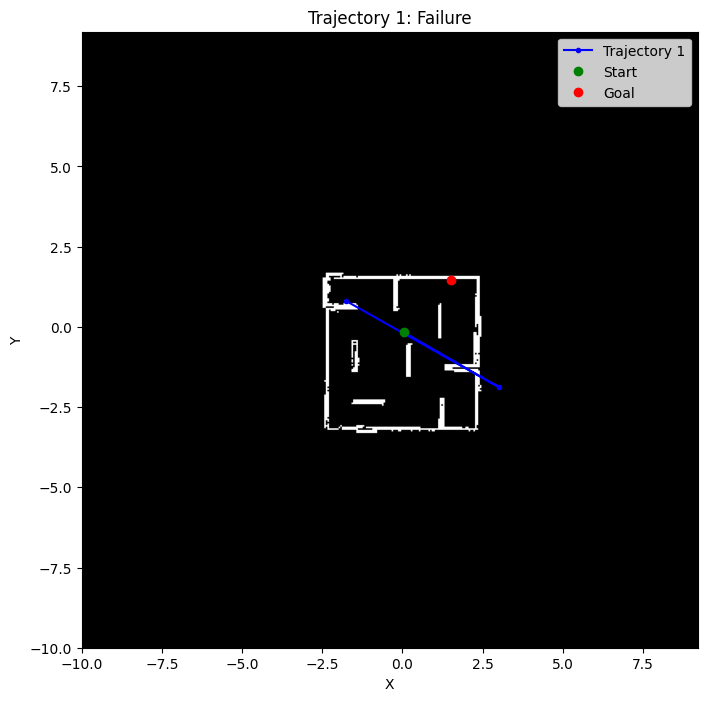

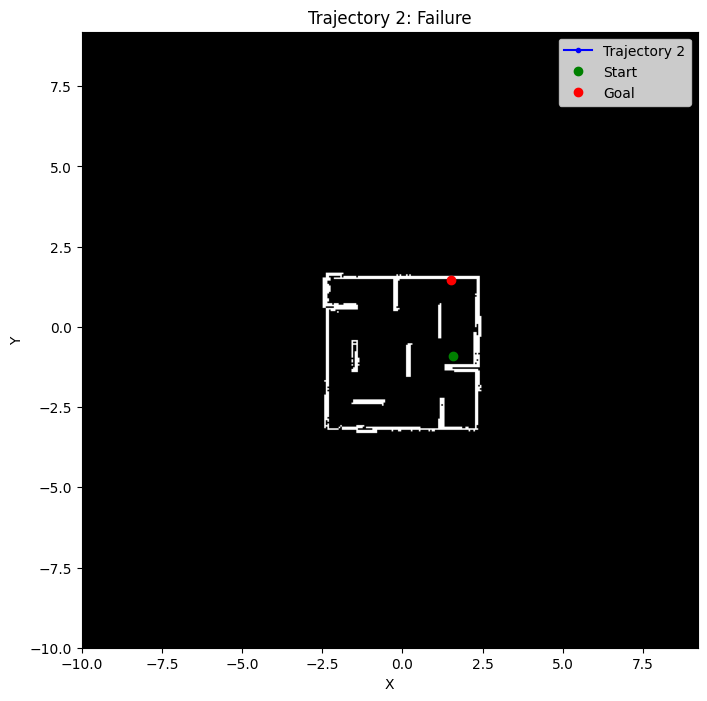

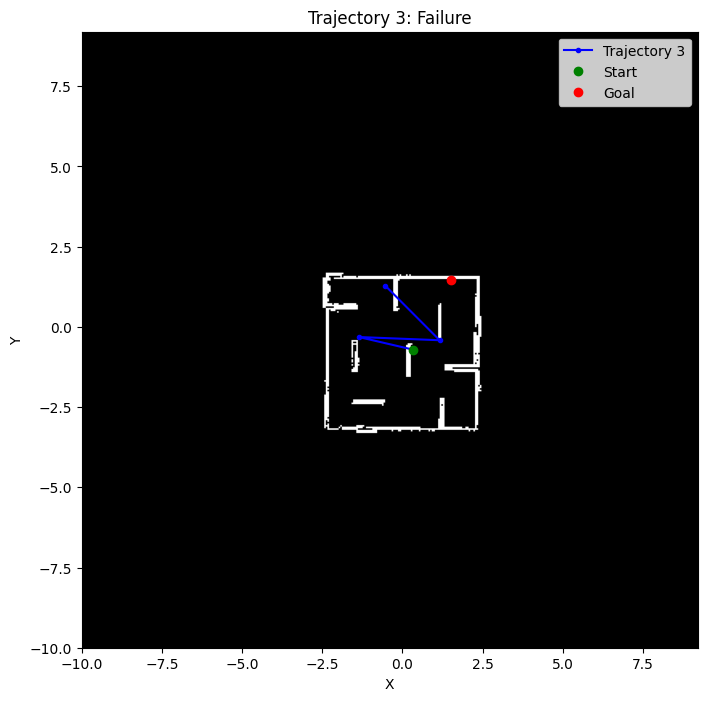

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate and plot 3 separate trajectories
num_trajectories_to_plot = 3
trajectories = []

for _ in range(num_trajectories_to_plot):
    start_x, start_y = get_random_start_position(map_object)
    path, success = generate_target_policy_path(
        start_x,
        start_y,
        map_object,
        actor,
        state_scaler,
        next_state_scaler,
        goal_position,
        max_steps=100
    )
    trajectories.append((path, success, (start_x, start_y)))

# Plot each trajectory separately
for idx, (path, success, start_pos) in enumerate(trajectories):
    plt.figure(figsize=(8, 8))
    plt.imshow(map_object.grid, cmap='gray', origin='lower', extent=map_object.limits)
    plt.xlabel('X')
    plt.ylabel('Y')

    # Convert the path to a numpy array for easier plotting
    path = np.array(path)

    # Plot the trajectory
    plt.plot(path[:, 0], path[:, 1], 'b.-', label=f'Trajectory {idx+1}')
    plt.plot(path[0, 0], path[0, 1], 'go', label='Start')
    plt.plot(goal_position[0], goal_position[1], 'ro', label='Goal')

    # Title and legend
    plt.title(f'Trajectory {idx+1}: {"Success" if success else "Failure"}')
    plt.legend()
    plt.show()
